<p>Project brief-introduction</p>
A binary classification task meant to classify images whether they showed a cat or a dog.

In [1]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Computer Vision
import cv2

#Sklearn
from sklearn.model_selection import train_test_split

#Tensorflow
from tensorflow.keras import (Model, 
                              Sequential)
from tensorflow.keras.layers import (Conv2D,
                                    MaxPooling2D,
                                    Dense,
                                    Flatten)
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# 1. Dataset creating & import

## 1.1 Dataset creating

In [2]:
filenames = os.listdir('dogs-vs-cats/train/')
categories = []
train = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    img_array = cv2.imread(os.path.join('dogs-vs-cats/train/', filename), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, dsize=(80, 80))
    train.append(img_array)

In [3]:
train_X = np.array(train).reshape(-1,80,80,1)
train_y = np.array(categories)
train_X_flattened = train_X.reshape(train_X.shape[0], -1)

# Create DataFrame
df_img = pd.DataFrame(train_X_flattened)

# Add category labels
df_img['Category'] = train_y
df_img.to_csv('train_data.csv', index=False)

## 1.2 Dataset Import and discovery

In [64]:
df = pd.read_csv('train_data.csv')

In [59]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,6391,6392,6393,6394,6395,6396,6397,6398,6399,Category
0,23,45,48,23,62,50,63,72,71,69,...,37,38,31,40,47,52,54,55,52,1
1,97,102,104,116,110,109,111,113,111,113,...,126,114,119,121,115,118,70,29,44,0
2,66,122,167,179,180,187,174,138,137,142,...,92,97,90,87,83,83,71,65,71,1
3,27,29,24,28,28,27,28,26,31,29,...,45,34,24,38,33,46,43,42,46,0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 6401 entries, 0 to Category
dtypes: int64(6401)
memory usage: 1.2 GB


This dataset does not have missing values.

In [28]:
sum(df.isna().sum()>0)

0

In [32]:
df[df.duplicated() == True]

,0,1,2,3,4,5,6,7,8,9,...,6391,6392,6393,6394,6395,6396,6397,6398,6399,Category
13798,226,222,221,219,217,143,192,177,162,158,...,36,36,36,36,40,41,50,50,49,1
20252,112,112,112,112,113,114,112,112,110,114,...,177,169,172,173,169,163,168,163,159,0
22470,250,250,247,252,254,254,253,253,255,254,...,231,147,140,144,139,130,114,247,253,1
22860,250,250,247,252,254,254,253,253,255,254,...,231,147,140,144,139,130,114,247,253,1
24490,78,119,73,82,70,84,120,83,124,122,...,228,209,235,235,240,229,222,238,225,0
24918,63,61,61,59,61,63,61,58,55,74,...,144,136,107,80,98,105,89,94,143,0


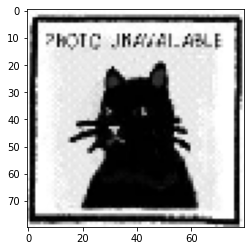

In [48]:
img_1 = df.iloc[22470, :]
img_2 = df.iloc[22860, :]

img_1 = img_1[:-1].to_numpy().astype(np.int64)
img_2 = img_2[:-1].to_numpy().astype(np.int64)

plt.imshow(img_1.reshape(80, 80), cmap='gray')


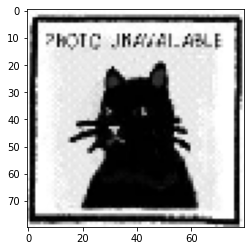

In [49]:
plt.imshow(img_2.reshape(80, 80), cmap='gray')

In [27]:
df['Category'].value_counts()

1    12500
0    12500
Name: Category, dtype: int64

## 1.3 Dataset preview

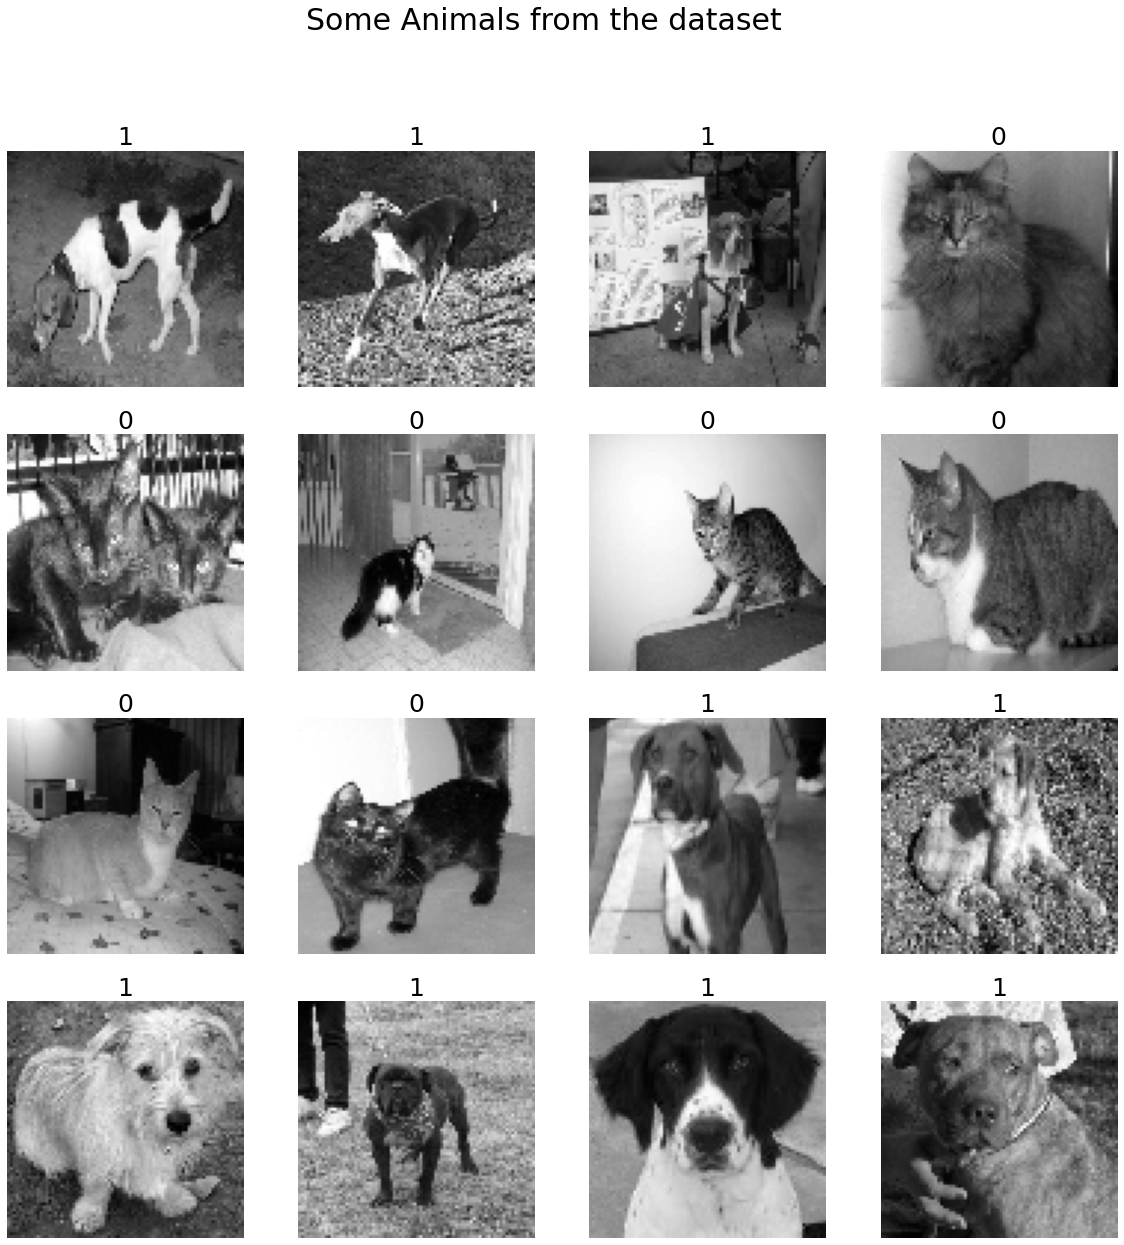

In [23]:
fig, axs = plt.subplots(4,4,figsize=(20,20))
fig.suptitle('Some Animals from the dataset', fontsize=30)
samples = df.sample(n=16)
imgs = samples.iloc[:, :-1].to_numpy().astype(np.int64)
labels = samples.iloc[:, -1].to_numpy()

for img, label, ax in zip(imgs, labels, axs.flatten()):
    ax.imshow(img.reshape(80, 80), cmap='gray')
    ax.set_title(label, fontsize=25)
    ax.axis('off')
    
plt.show()

<p>1. Basic discoveries</p>

<p>2. Outliers, Duplications, missing values checking</p>

<p>3. Correlations checking</p>

# 2. Data Preprocessing

## 2.1 Feature preprocessing: Encoding (/255)

In [65]:
df_pre = df.iloc[:, :-1]/255

In [66]:
df_pre

,0,1,2,3,4,5,6,7,8,9,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
0,0.090196,0.176471,0.188235,0.090196,0.243137,0.196078,0.247059,0.282353,0.278431,0.270588,...,0.137255,0.145098,0.149020,0.121569,0.156863,0.184314,0.203922,0.211765,0.215686,0.203922
1,0.380392,0.400000,0.407843,0.454902,0.431373,0.427451,0.435294,0.443137,0.435294,0.443137,...,0.568627,0.494118,0.447059,0.466667,0.474510,0.450980,0.462745,0.274510,0.113725,0.172549
2,0.258824,0.478431,0.654902,0.701961,0.705882,0.733333,0.682353,0.541176,0.537255,0.556863,...,0.431373,0.360784,0.380392,0.352941,0.341176,0.325490,0.325490,0.278431,0.254902,0.278431
3,0.105882,0.113725,0.094118,0.109804,0.109804,0.105882,0.109804,0.101961,0.121569,0.113725,...,0.078431,0.176471,0.133333,0.094118,0.149020,0.129412,0.180392,0.168627,0.164706,0.180392
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.082353,0.105882,0.117647,0.109804,0.121569,0.098039,0.105882,0.094118,0.090196,0.105882,...,0.282353,0.301961,0.282353,0.266667,0.282353,0.309804,0.305882,0.266667,0.282353,0.313725
24996,0.098039,0.313725,0.686275,0.392157,0.086275,0.070588,0.258824,0.105882,0.168627,0.184314,...,0.780392,0.874510,0.686275,0.682353,0.772549,0.403922,0.262745,0.352941,0.321569,0.431373
24997,0.011765,0.011765,0.011765,0.011765,0.015686,0.035294,0.031373,0.035294,0.047059,0.062745,...,0.623529,0.658824,0.576471,0.462745,0.458824,0.498039,0.450980,0.607843,0.454902,0.423529
24998,0.525490,0.525490,0.541176,0.556863,0.564706,0.588235,0.603922,0.615686,0.627451,0.643137,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [67]:
df_pre['Category'] = df['Category']

In [70]:
df = df_pre.copy()
df

,0,1,2,3,4,5,6,7,8,9,...,6391,6392,6393,6394,6395,6396,6397,6398,6399,Category
0,0.090196,0.176471,0.188235,0.090196,0.243137,0.196078,0.247059,0.282353,0.278431,0.270588,...,0.145098,0.149020,0.121569,0.156863,0.184314,0.203922,0.211765,0.215686,0.203922,1
1,0.380392,0.400000,0.407843,0.454902,0.431373,0.427451,0.435294,0.443137,0.435294,0.443137,...,0.494118,0.447059,0.466667,0.474510,0.450980,0.462745,0.274510,0.113725,0.172549,0
2,0.258824,0.478431,0.654902,0.701961,0.705882,0.733333,0.682353,0.541176,0.537255,0.556863,...,0.360784,0.380392,0.352941,0.341176,0.325490,0.325490,0.278431,0.254902,0.278431,1
3,0.105882,0.113725,0.094118,0.109804,0.109804,0.105882,0.109804,0.101961,0.121569,0.113725,...,0.176471,0.133333,0.094118,0.149020,0.129412,0.180392,0.168627,0.164706,0.180392,0
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.082353,0.105882,0.117647,0.109804,0.121569,0.098039,0.105882,0.094118,0.090196,0.105882,...,0.301961,0.282353,0.266667,0.282353,0.309804,0.305882,0.266667,0.282353,0.313725,1
24996,0.098039,0.313725,0.686275,0.392157,0.086275,0.070588,0.258824,0.105882,0.168627,0.184314,...,0.874510,0.686275,0.682353,0.772549,0.403922,0.262745,0.352941,0.321569,0.431373,1
24997,0.011765,0.011765,0.011765,0.011765,0.015686,0.035294,0.031373,0.035294,0.047059,0.062745,...,0.658824,0.576471,0.462745,0.458824,0.498039,0.450980,0.607843,0.454902,0.423529,1
24998,0.525490,0.525490,0.541176,0.556863,0.564706,0.588235,0.603922,0.615686,0.627451,0.643137,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0


## 3. Dataset splitting 
This dataset will be devided as follows:
<li>70% for training</li>
<li>20% for testing</li>
<li>10% for validation</li>

<b>Use stratify</b>

In [73]:
X, y = df.iloc[:, :-1], df.iloc[: , -1]

In [80]:
#Split training set and the combination of validation and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                    random_state=42, 
                                                    stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(17500, 6400)
(7500, 6400)
(17500,)
(7500,)
1    8750
0    8750
Name: Category, dtype: int64
1    3750
0    3750
Name: Category, dtype: int64


In [81]:
#Split validation and testing set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=1/3, 
                                                    random_state=42, 
                                                    stratify=y_test)
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_test.shape)
print(y_val.value_counts())
print(y_test.value_counts())

(2500, 6400)
(5000, 6400)
(2500,)
(5000,)
0    1250
1    1250
Name: Category, dtype: int64
1    2500
0    2500
Name: Category, dtype: int64


# 3. Model Building & Prediction

## 3.1 Model 1: Pre-training model

## 3.2 Model 2: CNN

### 3.2.1 Dataset shapping

In [88]:
X_train = X_train.to_numpy().reshape(-1, 80, 80, 1)
X_val = X_val.to_numpy().reshape(-1, 80, 80, 1)
X_test = X_test.to_numpy().reshape(-1, 80, 80, 1)

In [94]:
X_val.shape

(2500, 80, 80, 1)

### 3.2.2 Model building

In [89]:
CNN_model = Sequential()
CNN_model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(80,80,1)))
CNN_model.add(MaxPooling2D(pool_size= (2,2), strides=(2,2)))

CNN_model.add(Flatten())

CNN_model.add(Dense(512, activation='relu'))

CNN_model.add(Dense(2, activation='sigmoid'))



In [90]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               13107712  
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 13,108,898
Trainable params: 13,108,898
Non-trainable params: 0
__________________________________________

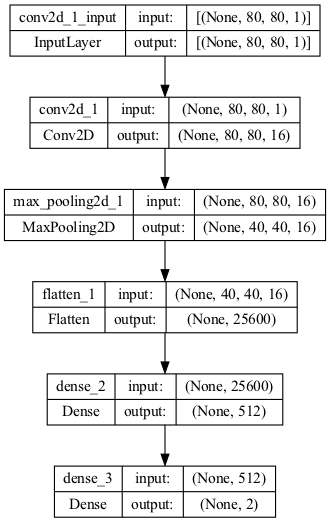

In [91]:
plot_model(CNN_model, show_shapes= True, expand_nested=True, dpi=80)

### 3.2.3 Model training and testing 

In [96]:
loss = 'sparse_categorical_crossentropy'
opt = Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2= 0.999, epsilon=1e-07)
metrics = ['accuracy']

CNN_model.compile(loss=loss, optimizer=opt, metrics=metrics)

CNN_model.history = CNN_model.fit(X_train,
                                  y_train,
                                  epochs=15,
                                  batch_size=128,
                                 validation_data= (X_val, y_val))

Epoch 1/15
137/137 [==============================] - 44s 320ms/step - loss: 0.5908 - accuracy: 0.6822 - val_loss: 0.5985 - val_accuracy: 0.6604
Epoch 2/15
137/137 [==============================] - 45s 331ms/step - loss: 0.5725 - accuracy: 0.6987 - val_loss: 0.5906 - val_accuracy: 0.6840
Epoch 3/15
137/137 [==============================] - 44s 318ms/step - loss: 0.5528 - accuracy: 0.7173 - val_loss: 0.5597 - val_accuracy: 0.7152
Epoch 4/15
137/137 [==============================] - 43s 314ms/step - loss: 0.5321 - accuracy: 0.7365 - val_loss: 0.5677 - val_accuracy: 0.6996
Epoch 5/15
137/137 [==============================] - 43s 316ms/step - loss: 0.5217 - accuracy: 0.7413 - val_loss: 0.5592 - val_accuracy: 0.7036
Epoch 6/15
137/137 [==============================] - 43s 311ms/step - loss: 0.5073 - accuracy: 0.7542 - val_loss: 0.5473 - val_accuracy: 0.7252
Epoch 7/15
137/137 [==============================] - 45s 327ms/step - loss: 0.4899 - accuracy: 0.7686 - val_loss: 0.5416 - val_ac

# 4. Result Comparison